In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchsummary import summary
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import numpy as np

# -----------------------------
# 1. Data Preprocessing
# -----------------------------
data_dir = "/kaggle/input/ju-cricket/Cricket_Dataset_final/Task_B"

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225])
])

train_ds = datasets.ImageFolder(f"{data_dir}/train/Bowling", transform=transform)
val_ds   = datasets.ImageFolder(f"{data_dir}/val/Bowling", transform=transform)
test_ds  = datasets.ImageFolder(f"{data_dir}/test/Bowling", transform=transform)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=32, shuffle=False)

classes = train_ds.classes
print("Classes:", classes)



Classes: ['fast_bowl', 'spin_bowl']


In [2]:
print("Total training images:", len(train_ds))
print("Total validation images:", len(val_ds))
print("Total test images:", len(test_ds))

total_images = len(train_ds) + len(val_ds) + len(test_ds)
print("Total images in dataset:", total_images)


Total training images: 1710
Total validation images: 432
Total test images: 549
Total images in dataset: 2691


In [3]:
ignore_folder = "random_occlusion"

def count_images_ignore_folder(dataset, ignore_folder):
    count = 0
    for img_path, label in dataset.samples:
        # Skip if the image path contains the ignore_folder
        if ignore_folder not in img_path.split("/"):
            count += 1
    return count

train_count = count_images_ignore_folder(train_ds, ignore_folder)
val_count   = count_images_ignore_folder(val_ds, ignore_folder)
test_count  = count_images_ignore_folder(test_ds, ignore_folder)

total_count = train_count + val_count + test_count

print("Training images (excluding '{}'): {}".format(ignore_folder, train_count))
print("Validation images (excluding '{}'): {}".format(ignore_folder, val_count))
print("Test images (excluding '{}'): {}".format(ignore_folder, test_count))
print("Total images (excluding '{}'): {}".format(ignore_folder, total_count))


Training images (excluding 'random_occlusion'): 1520
Validation images (excluding 'random_occlusion'): 384
Test images (excluding 'random_occlusion'): 488
Total images (excluding 'random_occlusion'): 2392


In [4]:
ignore_folder = "random_occlusionw"

def get_included_folders(dataset, ignore_folder):
    included = set()
    for img_path, label in dataset.samples:
        # Split the path into parts and ignore if ignore_folder is in the path
        if ignore_folder not in img_path.split("/"):
            # The folder name just above the image (or the class folder)
            folder_name = img_path.split("/")[-2]
            included.add(folder_name)
    return included

train_folders = get_included_folders(train_ds, ignore_folder)
val_folders   = get_included_folders(val_ds, ignore_folder)
test_folders  = get_included_folders(test_ds, ignore_folder)

print("Training folders considered:", train_folders)
print("Validation folders considered:", val_folders)
print("Test folders considered:", test_folders)


Training folders considered: {'dirty_lens', 'random_occlusion', 'gaussian_noise', 'blur', 'chromatic_aberration', 'low_resolution', 'original', 'lens_flare', 'motion_blur'}
Validation folders considered: {'dirty_lens', 'random_occlusion', 'gaussian_noise', 'blur', 'chromatic_aberration', 'low_resolution', 'original', 'lens_flare', 'motion_blur'}
Test folders considered: {'dirty_lens', 'random_occlusion', 'gaussian_noise', 'blur', 'chromatic_aberration', 'low_resolution', 'original', 'lens_flare', 'motion_blur'}


In [5]:
ignore_folder = "random_occlusion"

def filter_samples(dataset, ignore_folder):
    # Keep only samples where ignore_folder is NOT in the path
    filtered_samples = [s for s in dataset.samples if ignore_folder not in s[0].split("/")]
    dataset.samples = filtered_samples
    dataset.targets = [s[1] for s in filtered_samples]  # Update targets accordingly
    return dataset

# Create original datasets
train_ds = datasets.ImageFolder(f"{data_dir}/train/Bowling", transform=transform)
val_ds   = datasets.ImageFolder(f"{data_dir}/val/Bowling", transform=transform)
test_ds  = datasets.ImageFolder(f"{data_dir}/test/Bowling", transform=transform)

# Filter out 'random_occlusion' folder
train_ds = filter_samples(train_ds, ignore_folder)
val_ds   = filter_samples(val_ds, ignore_folder)
test_ds  = filter_samples(test_ds, ignore_folder)

# DataLoaders
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=32, shuffle=False)

# Classes (will remain the same)
classes = train_ds.classes
print("Classes:", classes)

# Show counts
print("Final Training images:", len(train_ds))
print("Final Validation images:", len(val_ds))
print("Final Test images:", len(test_ds))
print("Total images after filtering:", len(train_ds) + len(val_ds) + len(test_ds))


Classes: ['fast_bowl', 'spin_bowl']
Final Training images: 1520
Final Validation images: 384
Final Test images: 488
Total images after filtering: 2392


In [6]:
ignore_folder = "random_occlusion"

def get_included_folders(dataset, ignore_folder):
    included = set()
    for img_path, label in dataset.samples:
        # Split the path into parts and ignore if ignore_folder is in the path
        if ignore_folder not in img_path.split("/"):
            # The folder name just above the image (or the class folder)
            folder_name = img_path.split("/")[-2]
            included.add(folder_name)
    return included

train_folders = get_included_folders(train_ds, ignore_folder)
val_folders   = get_included_folders(val_ds, ignore_folder)
test_folders  = get_included_folders(test_ds, ignore_folder)

print("Training folders considered:", train_folders)
print("Validation folders considered:", val_folders)
print("Test folders considered:", test_folders)


Training folders considered: {'dirty_lens', 'gaussian_noise', 'blur', 'chromatic_aberration', 'low_resolution', 'original', 'lens_flare', 'motion_blur'}
Validation folders considered: {'dirty_lens', 'gaussian_noise', 'blur', 'chromatic_aberration', 'low_resolution', 'original', 'lens_flare', 'motion_blur'}
Test folders considered: {'dirty_lens', 'gaussian_noise', 'blur', 'chromatic_aberration', 'low_resolution', 'original', 'lens_flare', 'motion_blur'}


In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torchsummary import summary
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import numpy as np
import pandas as pd
from tqdm import tqdm
import time

classes = train_ds.classes
print("Classes:", classes)
print(f"Number of classes: {len(classes)}")
print(f"Train samples: {len(train_ds)}")
print(f"Val samples: {len(val_ds)}")
print(f"Test samples: {len(test_ds)}")

# -----------------------------
# 2. Pretrained MobileNetV2 Model
# -----------------------------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Load pretrained MobileNetV2
print("üîÑ Loading pretrained MobileNetV2 from ImageNet...")
model = models.mobilenet_v2(pretrained=True)

# Replace final classification layer
# MobileNetV2 has a different structure: model.classifier[1] instead of model.fc
num_features = model.classifier[1].in_features  # Get input features (1280)
model.classifier[1] = nn.Linear(num_features, len(classes))  # Replace final layer
model = model.to(device)

print(f"‚úÖ Model loaded with {len(classes)} output classes")
print(f"üìä Total parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"üìä Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

# Model summary
try:
    summary(model, (3, 224, 224))
except:
    print("Model summary not available")



Classes: ['fast_bowl', 'spin_bowl']
Number of classes: 2
Train samples: 1520
Val samples: 384
Test samples: 488
Using device: cuda
üîÑ Loading pretrained MobileNetV2 from ImageNet...


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 13.6M/13.6M [00:00<00:00, 112MB/s] 


‚úÖ Model loaded with 2 output classes
üìä Total parameters: 2,226,434
üìä Trainable parameters: 2,226,434
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
             ReLU6-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
             ReLU6-6         [-1, 32, 112, 112]               0
            Conv2d-7         [-1, 16, 112, 112]             512
       BatchNorm2d-8         [-1, 16, 112, 112]              32
  InvertedResidual-9         [-1, 16, 112, 112]               0
           Conv2d-10         [-1, 96, 112, 112]           1,536
      BatchNorm2d-11         [-1, 96, 112, 112]             192
            ReLU6-12         [-1, 96, 112, 112]           


üìã Training Configuration:
‚îÇ Model: MobileNetV2 (pretrained)
‚îÇ Optimizer: Adam (lr=0.0001)
‚îÇ Loss Function: CrossEntropyLoss
‚îÇ Batch Size: 32
‚îÇ Device: cuda

üöÄ Starting MobileNetV2 Fine-tuning for 50 epochs...

üìà Epoch 1/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:22<00:00,  2.09it/s, Loss=0.5103, Acc=0.7322]


‚úÖ Training completed in 22.96s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [00:03<00:00,  3.10it/s, Loss=0.6427, Acc=0.6432]


‚úÖ Validation completed in 3.87s
üåü New best model found! Validation Loss: 0.6427

üìä Epoch 1 Summary:
‚îÇ Train Loss: 0.5103 | Train Acc: 0.7322
‚îÇ Val Loss:   0.6427 | Val Acc:   0.6432
‚îÇ Train Time: 22.96s | Val Time: 3.87s
‚îÇ Total Epoch Time: 26.83s
‚îÇ Best Val Loss: 0.6427 (Epoch 1)
‚îÇ GPU Memory: 0.1GB / 2.8GB

üìà Epoch 2/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:16<00:00,  2.97it/s, Loss=0.1299, Acc=0.9612]


‚úÖ Training completed in 16.15s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [00:02<00:00,  5.00it/s, Loss=0.9938, Acc=0.6120]


‚úÖ Validation completed in 2.40s

üìä Epoch 2 Summary:
‚îÇ Train Loss: 0.1299 | Train Acc: 0.9612
‚îÇ Val Loss:   0.9938 | Val Acc:   0.6120
‚îÇ Train Time: 16.15s | Val Time: 2.40s
‚îÇ Total Epoch Time: 18.56s
‚îÇ Best Val Loss: 0.6427 (Epoch 1)
‚îÇ GPU Memory: 0.1GB / 2.8GB

üìà Epoch 3/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:16<00:00,  2.99it/s, Loss=0.0418, Acc=0.9895]


‚úÖ Training completed in 16.04s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [00:02<00:00,  4.96it/s, Loss=0.9530, Acc=0.6719]


‚úÖ Validation completed in 2.43s

üìä Epoch 3 Summary:
‚îÇ Train Loss: 0.0418 | Train Acc: 0.9895
‚îÇ Val Loss:   0.9530 | Val Acc:   0.6719
‚îÇ Train Time: 16.04s | Val Time: 2.43s
‚îÇ Total Epoch Time: 18.47s
‚îÇ Best Val Loss: 0.6427 (Epoch 1)
‚îÇ GPU Memory: 0.1GB / 2.8GB

üìà Epoch 4/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:16<00:00,  2.99it/s, Loss=0.0126, Acc=0.9993]


‚úÖ Training completed in 16.05s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [00:02<00:00,  4.80it/s, Loss=1.0426, Acc=0.6406]


‚úÖ Validation completed in 2.51s

üìä Epoch 4 Summary:
‚îÇ Train Loss: 0.0126 | Train Acc: 0.9993
‚îÇ Val Loss:   1.0426 | Val Acc:   0.6406
‚îÇ Train Time: 16.05s | Val Time: 2.51s
‚îÇ Total Epoch Time: 18.56s
‚îÇ Best Val Loss: 0.6427 (Epoch 1)
‚îÇ GPU Memory: 0.1GB / 2.8GB

üìà Epoch 5/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:16<00:00,  2.97it/s, Loss=0.0066, Acc=0.9993]


‚úÖ Training completed in 16.16s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [00:02<00:00,  5.01it/s, Loss=1.1043, Acc=0.6484]


‚úÖ Validation completed in 2.40s

üìä Epoch 5 Summary:
‚îÇ Train Loss: 0.0066 | Train Acc: 0.9993
‚îÇ Val Loss:   1.1043 | Val Acc:   0.6484
‚îÇ Train Time: 16.16s | Val Time: 2.40s
‚îÇ Total Epoch Time: 18.56s
‚îÇ Best Val Loss: 0.6427 (Epoch 1)
‚îÇ GPU Memory: 0.1GB / 2.8GB

üìà Epoch 6/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:16<00:00,  2.96it/s, Loss=0.0073, Acc=0.9993]


‚úÖ Training completed in 16.21s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [00:02<00:00,  4.55it/s, Loss=1.0621, Acc=0.6589]


‚úÖ Validation completed in 2.65s

üìä Epoch 6 Summary:
‚îÇ Train Loss: 0.0073 | Train Acc: 0.9993
‚îÇ Val Loss:   1.0621 | Val Acc:   0.6589
‚îÇ Train Time: 16.21s | Val Time: 2.65s
‚îÇ Total Epoch Time: 18.86s
‚îÇ Best Val Loss: 0.6427 (Epoch 1)
‚îÇ GPU Memory: 0.1GB / 2.8GB

üìà Epoch 7/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:16<00:00,  2.95it/s, Loss=0.0075, Acc=0.9980]


‚úÖ Training completed in 16.25s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [00:02<00:00,  5.07it/s, Loss=1.2503, Acc=0.6406]


‚úÖ Validation completed in 2.37s

üìä Epoch 7 Summary:
‚îÇ Train Loss: 0.0075 | Train Acc: 0.9980
‚îÇ Val Loss:   1.2503 | Val Acc:   0.6406
‚îÇ Train Time: 16.25s | Val Time: 2.37s
‚îÇ Total Epoch Time: 18.63s
‚îÇ Best Val Loss: 0.6427 (Epoch 1)
‚îÇ GPU Memory: 0.1GB / 2.8GB

üìà Epoch 8/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:16<00:00,  2.94it/s, Loss=0.0217, Acc=0.9941]


‚úÖ Training completed in 16.32s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [00:02<00:00,  4.71it/s, Loss=1.2288, Acc=0.6641]


‚úÖ Validation completed in 2.55s

üìä Epoch 8 Summary:
‚îÇ Train Loss: 0.0217 | Train Acc: 0.9941
‚îÇ Val Loss:   1.2288 | Val Acc:   0.6641
‚îÇ Train Time: 16.32s | Val Time: 2.55s
‚îÇ Total Epoch Time: 18.88s
‚îÇ Best Val Loss: 0.6427 (Epoch 1)
‚îÇ GPU Memory: 0.1GB / 2.8GB

üìà Epoch 9/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:16<00:00,  2.96it/s, Loss=0.0158, Acc=0.9954]


‚úÖ Training completed in 16.21s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [00:02<00:00,  4.81it/s, Loss=1.3816, Acc=0.5964]


‚úÖ Validation completed in 2.50s

üìä Epoch 9 Summary:
‚îÇ Train Loss: 0.0158 | Train Acc: 0.9954
‚îÇ Val Loss:   1.3816 | Val Acc:   0.5964
‚îÇ Train Time: 16.21s | Val Time: 2.50s
‚îÇ Total Epoch Time: 18.71s
‚îÇ Best Val Loss: 0.6427 (Epoch 1)
‚îÇ GPU Memory: 0.1GB / 2.8GB

üìà Epoch 10/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:16<00:00,  2.95it/s, Loss=0.0082, Acc=0.9980]


‚úÖ Training completed in 16.28s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [00:02<00:00,  4.96it/s, Loss=1.0811, Acc=0.6771]


‚úÖ Validation completed in 2.42s

üìä Epoch 10 Summary:
‚îÇ Train Loss: 0.0082 | Train Acc: 0.9980
‚îÇ Val Loss:   1.0811 | Val Acc:   0.6771
‚îÇ Train Time: 16.28s | Val Time: 2.42s
‚îÇ Total Epoch Time: 18.71s
‚îÇ Best Val Loss: 0.6427 (Epoch 1)
‚îÇ GPU Memory: 0.1GB / 2.8GB

üìà Epoch 11/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:16<00:00,  2.99it/s, Loss=0.0028, Acc=1.0000]


‚úÖ Training completed in 16.07s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [00:02<00:00,  4.94it/s, Loss=1.1928, Acc=0.6979]


‚úÖ Validation completed in 2.44s

üìä Epoch 11 Summary:
‚îÇ Train Loss: 0.0028 | Train Acc: 1.0000
‚îÇ Val Loss:   1.1928 | Val Acc:   0.6979
‚îÇ Train Time: 16.07s | Val Time: 2.44s
‚îÇ Total Epoch Time: 18.51s
‚îÇ Best Val Loss: 0.6427 (Epoch 1)
‚îÇ GPU Memory: 0.1GB / 2.8GB

üìà Epoch 12/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:16<00:00,  2.97it/s, Loss=0.0037, Acc=0.9993]


‚úÖ Training completed in 16.15s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [00:02<00:00,  4.67it/s, Loss=1.2693, Acc=0.6797]


‚úÖ Validation completed in 2.57s

üìä Epoch 12 Summary:
‚îÇ Train Loss: 0.0037 | Train Acc: 0.9993
‚îÇ Val Loss:   1.2693 | Val Acc:   0.6797
‚îÇ Train Time: 16.15s | Val Time: 2.57s
‚îÇ Total Epoch Time: 18.72s
‚îÇ Best Val Loss: 0.6427 (Epoch 1)
‚îÇ GPU Memory: 0.1GB / 2.8GB

üìà Epoch 13/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:16<00:00,  2.96it/s, Loss=0.0019, Acc=1.0000]


‚úÖ Training completed in 16.22s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [00:02<00:00,  4.83it/s, Loss=1.1617, Acc=0.6875]


‚úÖ Validation completed in 2.49s

üìä Epoch 13 Summary:
‚îÇ Train Loss: 0.0019 | Train Acc: 1.0000
‚îÇ Val Loss:   1.1617 | Val Acc:   0.6875
‚îÇ Train Time: 16.22s | Val Time: 2.49s
‚îÇ Total Epoch Time: 18.71s
‚îÇ Best Val Loss: 0.6427 (Epoch 1)
‚îÇ GPU Memory: 0.1GB / 2.8GB

üìà Epoch 14/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:16<00:00,  2.97it/s, Loss=0.0014, Acc=1.0000]


‚úÖ Training completed in 16.15s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [00:02<00:00,  4.89it/s, Loss=1.1921, Acc=0.7109]


‚úÖ Validation completed in 2.46s

üìä Epoch 14 Summary:
‚îÇ Train Loss: 0.0014 | Train Acc: 1.0000
‚îÇ Val Loss:   1.1921 | Val Acc:   0.7109
‚îÇ Train Time: 16.15s | Val Time: 2.46s
‚îÇ Total Epoch Time: 18.62s
‚îÇ Best Val Loss: 0.6427 (Epoch 1)
‚îÇ GPU Memory: 0.1GB / 2.8GB

üìà Epoch 15/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:16<00:00,  2.95it/s, Loss=0.0009, Acc=1.0000]


‚úÖ Training completed in 16.28s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [00:02<00:00,  4.80it/s, Loss=1.2706, Acc=0.6953]


‚úÖ Validation completed in 2.51s

üìä Epoch 15 Summary:
‚îÇ Train Loss: 0.0009 | Train Acc: 1.0000
‚îÇ Val Loss:   1.2706 | Val Acc:   0.6953
‚îÇ Train Time: 16.28s | Val Time: 2.51s
‚îÇ Total Epoch Time: 18.79s
‚îÇ Best Val Loss: 0.6427 (Epoch 1)
‚îÇ GPU Memory: 0.1GB / 2.8GB

üìà Epoch 16/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:16<00:00,  2.93it/s, Loss=0.0005, Acc=1.0000]


‚úÖ Training completed in 16.37s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [00:02<00:00,  4.81it/s, Loss=1.2734, Acc=0.6849]


‚úÖ Validation completed in 2.50s

üìä Epoch 16 Summary:
‚îÇ Train Loss: 0.0005 | Train Acc: 1.0000
‚îÇ Val Loss:   1.2734 | Val Acc:   0.6849
‚îÇ Train Time: 16.37s | Val Time: 2.50s
‚îÇ Total Epoch Time: 18.88s
‚îÇ Best Val Loss: 0.6427 (Epoch 1)
‚îÇ GPU Memory: 0.1GB / 2.8GB

üìà Epoch 17/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:16<00:00,  2.98it/s, Loss=0.0003, Acc=1.0000]


‚úÖ Training completed in 16.13s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [00:02<00:00,  4.93it/s, Loss=1.2732, Acc=0.6823]


‚úÖ Validation completed in 2.44s

üìä Epoch 17 Summary:
‚îÇ Train Loss: 0.0003 | Train Acc: 1.0000
‚îÇ Val Loss:   1.2732 | Val Acc:   0.6823
‚îÇ Train Time: 16.13s | Val Time: 2.44s
‚îÇ Total Epoch Time: 18.58s
‚îÇ Best Val Loss: 0.6427 (Epoch 1)
‚îÇ GPU Memory: 0.1GB / 2.8GB

üìà Epoch 18/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:16<00:00,  2.93it/s, Loss=0.0003, Acc=1.0000]


‚úÖ Training completed in 16.41s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [00:02<00:00,  4.94it/s, Loss=1.3677, Acc=0.6615]


‚úÖ Validation completed in 2.43s

üìä Epoch 18 Summary:
‚îÇ Train Loss: 0.0003 | Train Acc: 1.0000
‚îÇ Val Loss:   1.3677 | Val Acc:   0.6615
‚îÇ Train Time: 16.41s | Val Time: 2.43s
‚îÇ Total Epoch Time: 18.85s
‚îÇ Best Val Loss: 0.6427 (Epoch 1)
‚îÇ GPU Memory: 0.1GB / 2.8GB

üìà Epoch 19/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:16<00:00,  2.93it/s, Loss=0.0031, Acc=0.9993]


‚úÖ Training completed in 16.40s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [00:02<00:00,  4.71it/s, Loss=1.3411, Acc=0.6693]


‚úÖ Validation completed in 2.56s

üìä Epoch 19 Summary:
‚îÇ Train Loss: 0.0031 | Train Acc: 0.9993
‚îÇ Val Loss:   1.3411 | Val Acc:   0.6693
‚îÇ Train Time: 16.40s | Val Time: 2.56s
‚îÇ Total Epoch Time: 18.97s
‚îÇ Best Val Loss: 0.6427 (Epoch 1)
‚îÇ GPU Memory: 0.1GB / 2.8GB

üìà Epoch 20/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:16<00:00,  2.92it/s, Loss=0.0309, Acc=0.9914]


‚úÖ Training completed in 16.42s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [00:02<00:00,  4.86it/s, Loss=1.5037, Acc=0.6797]


‚úÖ Validation completed in 2.47s

üìä Epoch 20 Summary:
‚îÇ Train Loss: 0.0309 | Train Acc: 0.9914
‚îÇ Val Loss:   1.5037 | Val Acc:   0.6797
‚îÇ Train Time: 16.42s | Val Time: 2.47s
‚îÇ Total Epoch Time: 18.90s
‚îÇ Best Val Loss: 0.6427 (Epoch 1)
‚îÇ GPU Memory: 0.1GB / 2.8GB

üìà Epoch 21/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:16<00:00,  2.93it/s, Loss=0.0172, Acc=0.9954]


‚úÖ Training completed in 16.39s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [00:02<00:00,  4.95it/s, Loss=1.3711, Acc=0.6953]


‚úÖ Validation completed in 2.42s

üìä Epoch 21 Summary:
‚îÇ Train Loss: 0.0172 | Train Acc: 0.9954
‚îÇ Val Loss:   1.3711 | Val Acc:   0.6953
‚îÇ Train Time: 16.39s | Val Time: 2.42s
‚îÇ Total Epoch Time: 18.82s
‚îÇ Best Val Loss: 0.6427 (Epoch 1)
‚îÇ GPU Memory: 0.1GB / 2.8GB

üìà Epoch 22/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:16<00:00,  2.96it/s, Loss=0.0317, Acc=0.9895]


‚úÖ Training completed in 16.22s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [00:02<00:00,  4.73it/s, Loss=1.6901, Acc=0.6510]


‚úÖ Validation completed in 2.54s

üìä Epoch 22 Summary:
‚îÇ Train Loss: 0.0317 | Train Acc: 0.9895
‚îÇ Val Loss:   1.6901 | Val Acc:   0.6510
‚îÇ Train Time: 16.22s | Val Time: 2.54s
‚îÇ Total Epoch Time: 18.76s
‚îÇ Best Val Loss: 0.6427 (Epoch 1)
‚îÇ GPU Memory: 0.1GB / 2.8GB

üìà Epoch 23/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:16<00:00,  2.94it/s, Loss=0.0178, Acc=0.9947]


‚úÖ Training completed in 16.34s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [00:02<00:00,  4.86it/s, Loss=1.5128, Acc=0.6354]


‚úÖ Validation completed in 2.48s

üìä Epoch 23 Summary:
‚îÇ Train Loss: 0.0178 | Train Acc: 0.9947
‚îÇ Val Loss:   1.5128 | Val Acc:   0.6354
‚îÇ Train Time: 16.34s | Val Time: 2.48s
‚îÇ Total Epoch Time: 18.82s
‚îÇ Best Val Loss: 0.6427 (Epoch 1)
‚îÇ GPU Memory: 0.1GB / 2.8GB

üìà Epoch 24/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:16<00:00,  2.91it/s, Loss=0.0128, Acc=0.9974]


‚úÖ Training completed in 16.47s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [00:02<00:00,  4.85it/s, Loss=1.7266, Acc=0.6198]


‚úÖ Validation completed in 2.48s

üìä Epoch 24 Summary:
‚îÇ Train Loss: 0.0128 | Train Acc: 0.9974
‚îÇ Val Loss:   1.7266 | Val Acc:   0.6198
‚îÇ Train Time: 16.47s | Val Time: 2.48s
‚îÇ Total Epoch Time: 18.96s
‚îÇ Best Val Loss: 0.6427 (Epoch 1)
‚îÇ GPU Memory: 0.1GB / 2.8GB

üìà Epoch 25/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:16<00:00,  2.94it/s, Loss=0.0117, Acc=0.9954]


‚úÖ Training completed in 16.33s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [00:02<00:00,  4.77it/s, Loss=2.0155, Acc=0.6510]


‚úÖ Validation completed in 2.52s

üìä Epoch 25 Summary:
‚îÇ Train Loss: 0.0117 | Train Acc: 0.9954
‚îÇ Val Loss:   2.0155 | Val Acc:   0.6510
‚îÇ Train Time: 16.33s | Val Time: 2.52s
‚îÇ Total Epoch Time: 18.86s
‚îÇ Best Val Loss: 0.6427 (Epoch 1)
‚îÇ GPU Memory: 0.1GB / 2.8GB

üìà Epoch 26/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:16<00:00,  2.94it/s, Loss=0.0166, Acc=0.9961]


‚úÖ Training completed in 16.31s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [00:02<00:00,  4.90it/s, Loss=1.6473, Acc=0.6458]


‚úÖ Validation completed in 2.45s

üìä Epoch 26 Summary:
‚îÇ Train Loss: 0.0166 | Train Acc: 0.9961
‚îÇ Val Loss:   1.6473 | Val Acc:   0.6458
‚îÇ Train Time: 16.31s | Val Time: 2.45s
‚îÇ Total Epoch Time: 18.77s
‚îÇ Best Val Loss: 0.6427 (Epoch 1)
‚îÇ GPU Memory: 0.1GB / 2.8GB

üìà Epoch 27/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:16<00:00,  2.91it/s, Loss=0.0023, Acc=0.9993]


‚úÖ Training completed in 16.50s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [00:02<00:00,  5.00it/s, Loss=1.6716, Acc=0.6406]


‚úÖ Validation completed in 2.41s

üìä Epoch 27 Summary:
‚îÇ Train Loss: 0.0023 | Train Acc: 0.9993
‚îÇ Val Loss:   1.6716 | Val Acc:   0.6406
‚îÇ Train Time: 16.50s | Val Time: 2.41s
‚îÇ Total Epoch Time: 18.91s
‚îÇ Best Val Loss: 0.6427 (Epoch 1)
‚îÇ GPU Memory: 0.1GB / 2.8GB

üìà Epoch 28/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:16<00:00,  2.94it/s, Loss=0.0018, Acc=1.0000]


‚úÖ Training completed in 16.35s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [00:02<00:00,  4.94it/s, Loss=1.5681, Acc=0.6562]


‚úÖ Validation completed in 2.43s

üìä Epoch 28 Summary:
‚îÇ Train Loss: 0.0018 | Train Acc: 1.0000
‚îÇ Val Loss:   1.5681 | Val Acc:   0.6562
‚îÇ Train Time: 16.35s | Val Time: 2.43s
‚îÇ Total Epoch Time: 18.79s
‚îÇ Best Val Loss: 0.6427 (Epoch 1)
‚îÇ GPU Memory: 0.1GB / 2.8GB

üìà Epoch 29/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:16<00:00,  2.93it/s, Loss=0.0023, Acc=0.9987]


‚úÖ Training completed in 16.40s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [00:02<00:00,  4.91it/s, Loss=1.7537, Acc=0.6823]


‚úÖ Validation completed in 2.45s

üìä Epoch 29 Summary:
‚îÇ Train Loss: 0.0023 | Train Acc: 0.9987
‚îÇ Val Loss:   1.7537 | Val Acc:   0.6823
‚îÇ Train Time: 16.40s | Val Time: 2.45s
‚îÇ Total Epoch Time: 18.85s
‚îÇ Best Val Loss: 0.6427 (Epoch 1)
‚îÇ GPU Memory: 0.1GB / 2.8GB

üìà Epoch 30/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:16<00:00,  2.96it/s, Loss=0.0014, Acc=0.9993]


‚úÖ Training completed in 16.22s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [00:02<00:00,  4.91it/s, Loss=1.5392, Acc=0.6536]


‚úÖ Validation completed in 2.44s

üìä Epoch 30 Summary:
‚îÇ Train Loss: 0.0014 | Train Acc: 0.9993
‚îÇ Val Loss:   1.5392 | Val Acc:   0.6536
‚îÇ Train Time: 16.22s | Val Time: 2.44s
‚îÇ Total Epoch Time: 18.67s
‚îÇ Best Val Loss: 0.6427 (Epoch 1)
‚îÇ GPU Memory: 0.1GB / 2.8GB

üìà Epoch 31/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:16<00:00,  2.91it/s, Loss=0.0005, Acc=1.0000]


‚úÖ Training completed in 16.49s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [00:02<00:00,  4.85it/s, Loss=1.5394, Acc=0.6510]


‚úÖ Validation completed in 2.48s

üìä Epoch 31 Summary:
‚îÇ Train Loss: 0.0005 | Train Acc: 1.0000
‚îÇ Val Loss:   1.5394 | Val Acc:   0.6510
‚îÇ Train Time: 16.49s | Val Time: 2.48s
‚îÇ Total Epoch Time: 18.97s
‚îÇ Best Val Loss: 0.6427 (Epoch 1)
‚îÇ GPU Memory: 0.1GB / 2.8GB

üìà Epoch 32/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:16<00:00,  2.91it/s, Loss=0.0046, Acc=0.9987]


‚úÖ Training completed in 16.50s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [00:02<00:00,  4.59it/s, Loss=1.5412, Acc=0.6771]


‚úÖ Validation completed in 2.62s

üìä Epoch 32 Summary:
‚îÇ Train Loss: 0.0046 | Train Acc: 0.9987
‚îÇ Val Loss:   1.5412 | Val Acc:   0.6771
‚îÇ Train Time: 16.50s | Val Time: 2.62s
‚îÇ Total Epoch Time: 19.13s
‚îÇ Best Val Loss: 0.6427 (Epoch 1)
‚îÇ GPU Memory: 0.1GB / 2.8GB

üìà Epoch 33/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:16<00:00,  2.96it/s, Loss=0.0026, Acc=1.0000]


‚úÖ Training completed in 16.22s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [00:02<00:00,  4.86it/s, Loss=1.5802, Acc=0.6771]


‚úÖ Validation completed in 2.47s

üìä Epoch 33 Summary:
‚îÇ Train Loss: 0.0026 | Train Acc: 1.0000
‚îÇ Val Loss:   1.5802 | Val Acc:   0.6771
‚îÇ Train Time: 16.22s | Val Time: 2.47s
‚îÇ Total Epoch Time: 18.69s
‚îÇ Best Val Loss: 0.6427 (Epoch 1)
‚îÇ GPU Memory: 0.1GB / 2.8GB

üìà Epoch 34/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:16<00:00,  2.93it/s, Loss=0.0021, Acc=0.9993]


‚úÖ Training completed in 16.39s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [00:02<00:00,  4.99it/s, Loss=1.6443, Acc=0.6354]


‚úÖ Validation completed in 2.41s

üìä Epoch 34 Summary:
‚îÇ Train Loss: 0.0021 | Train Acc: 0.9993
‚îÇ Val Loss:   1.6443 | Val Acc:   0.6354
‚îÇ Train Time: 16.39s | Val Time: 2.41s
‚îÇ Total Epoch Time: 18.81s
‚îÇ Best Val Loss: 0.6427 (Epoch 1)
‚îÇ GPU Memory: 0.1GB / 2.8GB

üìà Epoch 35/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:16<00:00,  2.96it/s, Loss=0.0003, Acc=1.0000]


‚úÖ Training completed in 16.23s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [00:02<00:00,  4.94it/s, Loss=1.5938, Acc=0.6562]


‚úÖ Validation completed in 2.43s

üìä Epoch 35 Summary:
‚îÇ Train Loss: 0.0003 | Train Acc: 1.0000
‚îÇ Val Loss:   1.5938 | Val Acc:   0.6562
‚îÇ Train Time: 16.23s | Val Time: 2.43s
‚îÇ Total Epoch Time: 18.66s
‚îÇ Best Val Loss: 0.6427 (Epoch 1)
‚îÇ GPU Memory: 0.1GB / 2.8GB

üìà Epoch 36/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:16<00:00,  2.93it/s, Loss=0.0030, Acc=0.9987]


‚úÖ Training completed in 16.39s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [00:02<00:00,  5.08it/s, Loss=1.5047, Acc=0.6849]


‚úÖ Validation completed in 2.37s

üìä Epoch 36 Summary:
‚îÇ Train Loss: 0.0030 | Train Acc: 0.9987
‚îÇ Val Loss:   1.5047 | Val Acc:   0.6849
‚îÇ Train Time: 16.39s | Val Time: 2.37s
‚îÇ Total Epoch Time: 18.77s
‚îÇ Best Val Loss: 0.6427 (Epoch 1)
‚îÇ GPU Memory: 0.1GB / 2.8GB

üìà Epoch 37/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:16<00:00,  2.94it/s, Loss=0.0013, Acc=1.0000]


‚úÖ Training completed in 16.34s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [00:02<00:00,  4.86it/s, Loss=1.7253, Acc=0.6589]


‚úÖ Validation completed in 2.47s

üìä Epoch 37 Summary:
‚îÇ Train Loss: 0.0013 | Train Acc: 1.0000
‚îÇ Val Loss:   1.7253 | Val Acc:   0.6589
‚îÇ Train Time: 16.34s | Val Time: 2.47s
‚îÇ Total Epoch Time: 18.81s
‚îÇ Best Val Loss: 0.6427 (Epoch 1)
‚îÇ GPU Memory: 0.1GB / 2.8GB

üìà Epoch 38/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:16<00:00,  2.93it/s, Loss=0.0010, Acc=1.0000]


‚úÖ Training completed in 16.36s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [00:02<00:00,  4.88it/s, Loss=1.8170, Acc=0.6432]


‚úÖ Validation completed in 2.47s

üìä Epoch 38 Summary:
‚îÇ Train Loss: 0.0010 | Train Acc: 1.0000
‚îÇ Val Loss:   1.8170 | Val Acc:   0.6432
‚îÇ Train Time: 16.36s | Val Time: 2.47s
‚îÇ Total Epoch Time: 18.83s
‚îÇ Best Val Loss: 0.6427 (Epoch 1)
‚îÇ GPU Memory: 0.1GB / 2.8GB

üìà Epoch 39/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:16<00:00,  2.91it/s, Loss=0.0003, Acc=1.0000]


‚úÖ Training completed in 16.52s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [00:02<00:00,  4.89it/s, Loss=1.7630, Acc=0.6458]


‚úÖ Validation completed in 2.46s

üìä Epoch 39 Summary:
‚îÇ Train Loss: 0.0003 | Train Acc: 1.0000
‚îÇ Val Loss:   1.7630 | Val Acc:   0.6458
‚îÇ Train Time: 16.52s | Val Time: 2.46s
‚îÇ Total Epoch Time: 18.98s
‚îÇ Best Val Loss: 0.6427 (Epoch 1)
‚îÇ GPU Memory: 0.1GB / 2.8GB

üìà Epoch 40/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:16<00:00,  2.97it/s, Loss=0.0002, Acc=1.0000]


‚úÖ Training completed in 16.19s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [00:02<00:00,  4.71it/s, Loss=1.6965, Acc=0.6458]


‚úÖ Validation completed in 2.55s

üìä Epoch 40 Summary:
‚îÇ Train Loss: 0.0002 | Train Acc: 1.0000
‚îÇ Val Loss:   1.6965 | Val Acc:   0.6458
‚îÇ Train Time: 16.19s | Val Time: 2.55s
‚îÇ Total Epoch Time: 18.74s
‚îÇ Best Val Loss: 0.6427 (Epoch 1)
‚îÇ GPU Memory: 0.1GB / 2.8GB

üìà Epoch 41/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:16<00:00,  2.94it/s, Loss=0.0003, Acc=1.0000]


‚úÖ Training completed in 16.34s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [00:02<00:00,  4.77it/s, Loss=1.6628, Acc=0.6667]


‚úÖ Validation completed in 2.52s

üìä Epoch 41 Summary:
‚îÇ Train Loss: 0.0003 | Train Acc: 1.0000
‚îÇ Val Loss:   1.6628 | Val Acc:   0.6667
‚îÇ Train Time: 16.34s | Val Time: 2.52s
‚îÇ Total Epoch Time: 18.86s
‚îÇ Best Val Loss: 0.6427 (Epoch 1)
‚îÇ GPU Memory: 0.1GB / 2.8GB

üìà Epoch 42/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:16<00:00,  2.91it/s, Loss=0.0002, Acc=1.0000]


‚úÖ Training completed in 16.51s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [00:02<00:00,  5.00it/s, Loss=1.6889, Acc=0.6562]


‚úÖ Validation completed in 2.40s

üìä Epoch 42 Summary:
‚îÇ Train Loss: 0.0002 | Train Acc: 1.0000
‚îÇ Val Loss:   1.6889 | Val Acc:   0.6562
‚îÇ Train Time: 16.51s | Val Time: 2.40s
‚îÇ Total Epoch Time: 18.92s
‚îÇ Best Val Loss: 0.6427 (Epoch 1)
‚îÇ GPU Memory: 0.1GB / 2.8GB

üìà Epoch 43/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:16<00:00,  2.96it/s, Loss=0.0003, Acc=1.0000]


‚úÖ Training completed in 16.20s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [00:02<00:00,  4.86it/s, Loss=1.6768, Acc=0.6667]


‚úÖ Validation completed in 2.48s

üìä Epoch 43 Summary:
‚îÇ Train Loss: 0.0003 | Train Acc: 1.0000
‚îÇ Val Loss:   1.6768 | Val Acc:   0.6667
‚îÇ Train Time: 16.20s | Val Time: 2.48s
‚îÇ Total Epoch Time: 18.68s
‚îÇ Best Val Loss: 0.6427 (Epoch 1)
‚îÇ GPU Memory: 0.1GB / 2.8GB

üìà Epoch 44/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:16<00:00,  2.93it/s, Loss=0.0001, Acc=1.0000]


‚úÖ Training completed in 16.40s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [00:02<00:00,  4.65it/s, Loss=1.7061, Acc=0.6302]


‚úÖ Validation completed in 2.59s

üìä Epoch 44 Summary:
‚îÇ Train Loss: 0.0001 | Train Acc: 1.0000
‚îÇ Val Loss:   1.7061 | Val Acc:   0.6302
‚îÇ Train Time: 16.40s | Val Time: 2.59s
‚îÇ Total Epoch Time: 18.99s
‚îÇ Best Val Loss: 0.6427 (Epoch 1)
‚îÇ GPU Memory: 0.1GB / 2.8GB

üìà Epoch 45/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:16<00:00,  2.88it/s, Loss=0.0001, Acc=1.0000]


‚úÖ Training completed in 16.68s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [00:02<00:00,  4.94it/s, Loss=1.7252, Acc=0.6510]


‚úÖ Validation completed in 2.44s

üìä Epoch 45 Summary:
‚îÇ Train Loss: 0.0001 | Train Acc: 1.0000
‚îÇ Val Loss:   1.7252 | Val Acc:   0.6510
‚îÇ Train Time: 16.68s | Val Time: 2.44s
‚îÇ Total Epoch Time: 19.12s
‚îÇ Best Val Loss: 0.6427 (Epoch 1)
‚îÇ GPU Memory: 0.1GB / 2.8GB

üìà Epoch 46/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:16<00:00,  2.94it/s, Loss=0.0001, Acc=1.0000]


‚úÖ Training completed in 16.33s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [00:02<00:00,  4.85it/s, Loss=1.7007, Acc=0.6536]


‚úÖ Validation completed in 2.48s

üìä Epoch 46 Summary:
‚îÇ Train Loss: 0.0001 | Train Acc: 1.0000
‚îÇ Val Loss:   1.7007 | Val Acc:   0.6536
‚îÇ Train Time: 16.33s | Val Time: 2.48s
‚îÇ Total Epoch Time: 18.81s
‚îÇ Best Val Loss: 0.6427 (Epoch 1)
‚îÇ GPU Memory: 0.1GB / 2.8GB

üìà Epoch 47/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:16<00:00,  2.90it/s, Loss=0.0001, Acc=1.0000]


‚úÖ Training completed in 16.55s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [00:02<00:00,  4.90it/s, Loss=1.6352, Acc=0.6745]


‚úÖ Validation completed in 2.45s

üìä Epoch 47 Summary:
‚îÇ Train Loss: 0.0001 | Train Acc: 1.0000
‚îÇ Val Loss:   1.6352 | Val Acc:   0.6745
‚îÇ Train Time: 16.55s | Val Time: 2.45s
‚îÇ Total Epoch Time: 19.01s
‚îÇ Best Val Loss: 0.6427 (Epoch 1)
‚îÇ GPU Memory: 0.1GB / 2.8GB

üìà Epoch 48/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:16<00:00,  2.93it/s, Loss=0.0001, Acc=1.0000]


‚úÖ Training completed in 16.39s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [00:02<00:00,  4.94it/s, Loss=1.6419, Acc=0.6641]


‚úÖ Validation completed in 2.44s

üìä Epoch 48 Summary:
‚îÇ Train Loss: 0.0001 | Train Acc: 1.0000
‚îÇ Val Loss:   1.6419 | Val Acc:   0.6641
‚îÇ Train Time: 16.39s | Val Time: 2.44s
‚îÇ Total Epoch Time: 18.83s
‚îÇ Best Val Loss: 0.6427 (Epoch 1)
‚îÇ GPU Memory: 0.1GB / 2.8GB

üìà Epoch 49/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:16<00:00,  2.95it/s, Loss=0.0002, Acc=1.0000]


‚úÖ Training completed in 16.27s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [00:02<00:00,  5.02it/s, Loss=1.6877, Acc=0.6693]


‚úÖ Validation completed in 2.39s

üìä Epoch 49 Summary:
‚îÇ Train Loss: 0.0002 | Train Acc: 1.0000
‚îÇ Val Loss:   1.6877 | Val Acc:   0.6693
‚îÇ Train Time: 16.27s | Val Time: 2.39s
‚îÇ Total Epoch Time: 18.67s
‚îÇ Best Val Loss: 0.6427 (Epoch 1)
‚îÇ GPU Memory: 0.1GB / 2.8GB

üìà Epoch 50/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:16<00:00,  2.98it/s, Loss=0.0001, Acc=1.0000]


‚úÖ Training completed in 16.09s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [00:02<00:00,  4.93it/s, Loss=1.7455, Acc=0.6536]


‚úÖ Validation completed in 2.44s

üìä Epoch 50 Summary:
‚îÇ Train Loss: 0.0001 | Train Acc: 1.0000
‚îÇ Val Loss:   1.7455 | Val Acc:   0.6536
‚îÇ Train Time: 16.09s | Val Time: 2.44s
‚îÇ Total Epoch Time: 18.53s
‚îÇ Best Val Loss: 0.6427 (Epoch 1)
‚îÇ GPU Memory: 0.1GB / 2.8GB

üíæ Best model saved as 'best_cricket_mobilenetv2.pth'
üìä Best model stats:
‚îÇ Best Epoch: 1
‚îÇ Best Val Loss: 0.6427
‚îÇ Best Val Acc: 0.6432

üíæ Training history saved to 'cricket_mobilenetv2_history_pretrained.csv'

üéâ MobileNetV2 Fine-tuning Complete!
Total Training Time: 947.32s (15.8 minutes)
Average Epoch Time: 18.95s

üß™ Loading Best Model for Testing...
‚úÖ Best model from epoch 1 loaded successfully!


Testing: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 16/16 [00:05<00:00,  2.87it/s]


‚úÖ Testing completed in 5.57s

üìã Classification Report:
              precision    recall  f1-score   support

   fast_bowl       0.75      0.73      0.74       304
   spin_bowl       0.57      0.59      0.58       184

    accuracy                           0.68       488
   macro avg       0.66      0.66      0.66       488
weighted avg       0.68      0.68      0.68       488

üéØ Test Accuracy: 0.6783

üìä Cricket Classification Performance (MobileNetV2):
‚îÇ Best Validation Loss: 0.6427 (Epoch 1)
‚îÇ Best Validation Acc:  0.6432 (Epoch 1)
‚îÇ Final Test Accuracy:  0.6783
‚îÇ Val-Test Gap:         0.0350

üíæ Files saved:
‚îÇ best_cricket_mobilenetv2.pth - Best model weights
‚îÇ cricket_mobilenetv2_history.csv - Training metrics


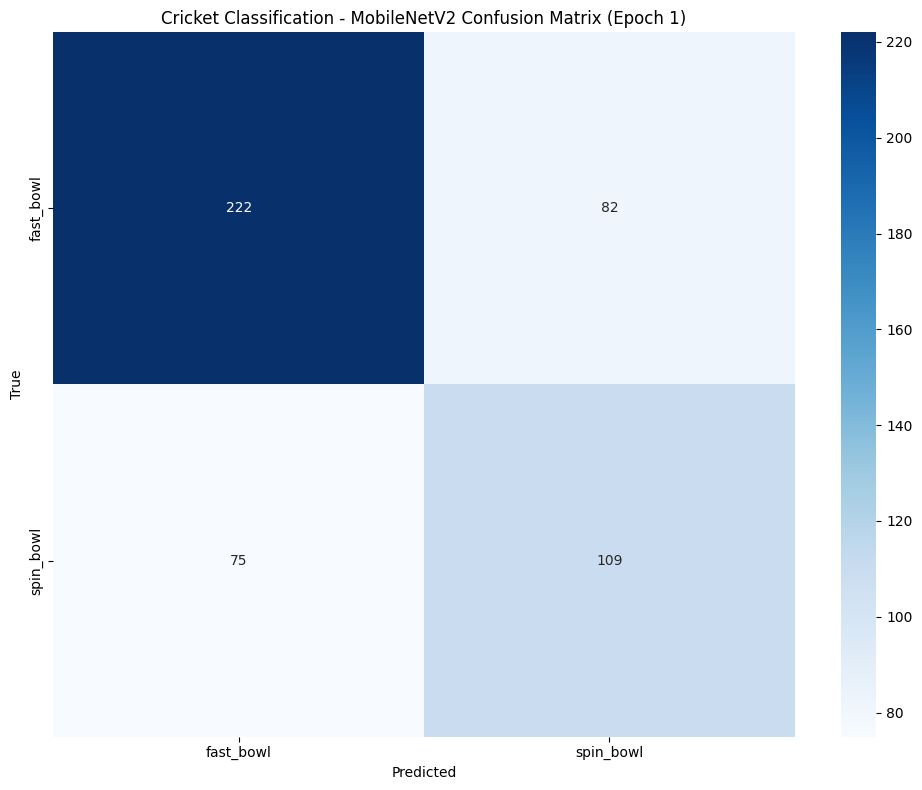

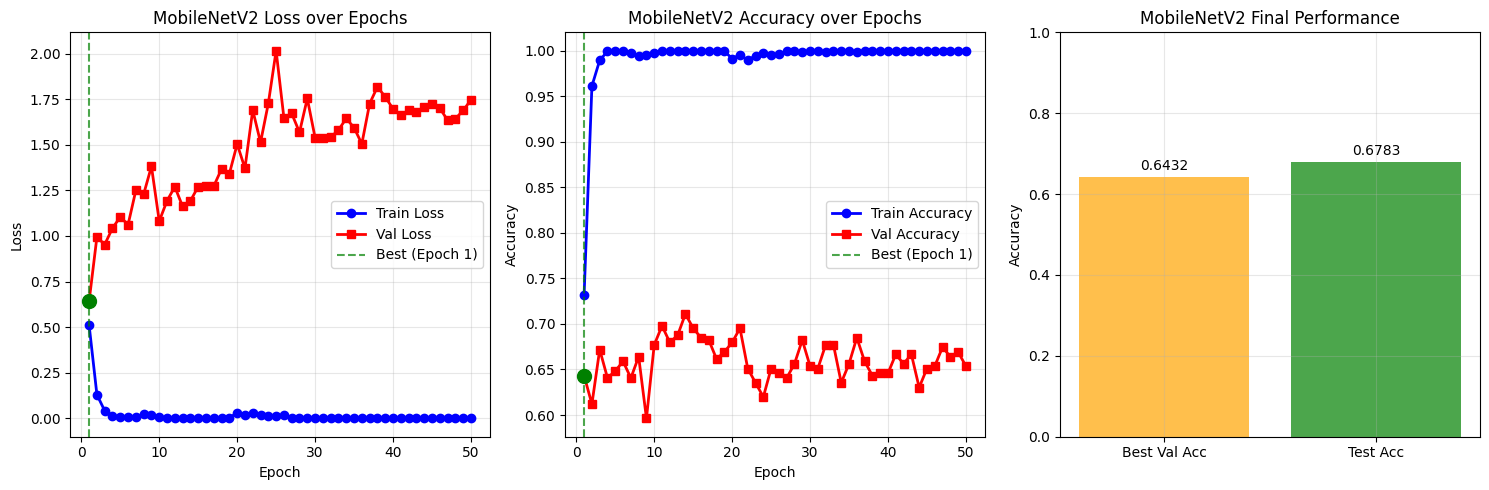


‚è∞ Final Timing Summary:
‚îÇ Total Training: 947.32s (15.8 min)
‚îÇ Average per Epoch: 18.95s
‚îÇ Testing Time: 5.57s
‚îÇ Total Runtime: 952.89s

üì± MobileNetV2 Advantages:
‚îÇ Lightweight: ~3.5M parameters vs ~25M (ResNet50)
‚îÇ Mobile-optimized: Designed for resource-constrained devices
‚îÇ Faster training: Typically trains faster than ResNet50
‚îÇ Lower memory: Uses less GPU memory during training


In [8]:
# -----------------------------
# 3. Training Setup
# -----------------------------
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)  # Lower LR for fine-tuning

print(f"\nüìã Training Configuration:")
print(f"‚îÇ Model: MobileNetV2 (pretrained)")
print(f"‚îÇ Optimizer: Adam (lr={optimizer.param_groups[0]['lr']})")
print(f"‚îÇ Loss Function: CrossEntropyLoss")
print(f"‚îÇ Batch Size: 32")
print(f"‚îÇ Device: {device}")

# -----------------------------
# 4. Training Loop with Model Saving
# -----------------------------
train_losses, val_losses = [], []
train_accs, val_accs = [], []
epoch_times = []
epochs = 50

# Initialize best model tracking (using val_loss for fine-tuning)
best_val_loss = float('inf')
best_model_state = None
best_epoch = 0
best_val_acc = 0.0

print(f"\nüöÄ Starting MobileNetV2 Fine-tuning for {epochs} epochs...")
print("=" * 80)
total_start_time = time.time()

for epoch in range(epochs):
    epoch_start_time = time.time()
    
    print(f"\nüìà Epoch {epoch+1}/{epochs}")
    print("-" * 50)
    
    # Training Phase
    print("üîÑ Training Phase...")
    model.train()
    running_loss, correct, total = 0, 0, 0
    
    train_pbar = tqdm(train_loader, desc="Training", 
                     bar_format='{l_bar}{bar:30}{r_bar}{bar:-30b}')
    
    train_phase_start = time.time()
    
    for batch_idx, (imgs, labels) in enumerate(train_pbar):
        imgs, labels = imgs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        
        current_acc = correct / total
        train_pbar.set_postfix({
            'Loss': f'{running_loss/(batch_idx+1):.4f}',
            'Acc': f'{current_acc:.4f}'
        })
        
        if device.type == 'cuda' and batch_idx % 10 == 0:
            gpu_memory = torch.cuda.memory_allocated() / 1024**3
            train_pbar.set_postfix({
                'Loss': f'{running_loss/(batch_idx+1):.4f}',
                'Acc': f'{current_acc:.4f}',
                'GPU': f'{gpu_memory:.1f}GB'
            })
    
    train_phase_time = time.time() - train_phase_start
    train_loss = running_loss / len(train_loader)
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    
    print(f"‚úÖ Training completed in {train_phase_time:.2f}s")
    
    # Validation Phase
    print("üîç Validation Phase...")
    model.eval()
    running_loss, correct, total = 0, 0, 0
    
    val_phase_start = time.time()
    val_pbar = tqdm(val_loader, desc="Validation", 
                   bar_format='{l_bar}{bar:30}{r_bar}{bar:-30b}')
    
    with torch.no_grad():
        for batch_idx, (imgs, labels) in enumerate(val_pbar):
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            
            current_acc = correct / total
            val_pbar.set_postfix({
                'Loss': f'{running_loss/(batch_idx+1):.4f}',
                'Acc': f'{current_acc:.4f}'
            })
    
    val_phase_time = time.time() - val_phase_start
    val_loss = running_loss / len(val_loader)
    val_acc = correct / total
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    print(f"‚úÖ Validation completed in {val_phase_time:.2f}s")
    
    # Check if this is the best model (using val_loss for fine-tuning)
    is_best = val_loss < best_val_loss
    if is_best:
        best_val_loss = val_loss
        best_val_acc = val_acc
        best_epoch = epoch + 1
        best_model_state = model.state_dict().copy()
        print(f"üåü New best model found! Validation Loss: {val_loss:.4f}")
    
    # Epoch Summary
    epoch_time = time.time() - epoch_start_time
    epoch_times.append(epoch_time)
    
    print(f"\nüìä Epoch {epoch+1} Summary:")
    print(f"‚îÇ Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"‚îÇ Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.4f}")
    print(f"‚îÇ Train Time: {train_phase_time:.2f}s | Val Time: {val_phase_time:.2f}s")
    print(f"‚îÇ Total Epoch Time: {epoch_time:.2f}s")
    print(f"‚îÇ Best Val Loss: {best_val_loss:.4f} (Epoch {best_epoch})")
    
    if device.type == 'cuda':
        print(f"‚îÇ GPU Memory: {torch.cuda.memory_allocated()/1024**3:.1f}GB / {torch.cuda.memory_reserved()/1024**3:.1f}GB")
    
    print("=" * 80)

total_training_time = time.time() - total_start_time

# Save the best model
if best_model_state is not None:
    torch.save(best_model_state, 'best_cricket_mobilenetv2_pretrained.pth')
    print(f"\nüíæ Best model saved as 'best_cricket_mobilenetv2.pth'")
    print(f"üìä Best model stats:")
    print(f"‚îÇ Best Epoch: {best_epoch}")
    print(f"‚îÇ Best Val Loss: {best_val_loss:.4f}")
    print(f"‚îÇ Best Val Acc: {best_val_acc:.4f}")

# Save training history
history_data = {
    'epoch': list(range(1, epochs+1)),
    'train_loss': train_losses,
    'val_loss': val_losses,
    'train_acc': train_accs,
    'val_acc': val_accs,
    'epoch_time': epoch_times
}

history_df = pd.DataFrame(history_data)
history_df.to_csv('cricket_mobilenetv2_history_pretrained.csv', index=False)
print("\nüíæ Training history saved to 'cricket_mobilenetv2_history_pretrained.csv'")

print(f"\nüéâ MobileNetV2 Fine-tuning Complete!")
print(f"Total Training Time: {total_training_time:.2f}s ({total_training_time/60:.1f} minutes)")
print(f"Average Epoch Time: {np.mean(epoch_times):.2f}s")

# -----------------------------
# 5. Load Best Model and Test
# -----------------------------
print(f"\nüß™ Loading Best Model for Testing...")
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print(f"‚úÖ Best model from epoch {best_epoch} loaded successfully!")

test_start_time = time.time()
y_true, y_pred = [], []
model.eval()
test_pbar = tqdm(test_loader, desc="Testing", 
                bar_format='{l_bar}{bar:30}{r_bar}{bar:-30b}')

with torch.no_grad():
    for imgs, labels in test_pbar:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

test_time = time.time() - test_start_time
test_accuracy = accuracy_score(y_true, y_pred)

print(f"‚úÖ Testing completed in {test_time:.2f}s")
print("\nüìã Classification Report:")
print(classification_report(y_true, y_pred, target_names=classes))
print(f"üéØ Test Accuracy: {test_accuracy:.4f}")

# Performance Summary
print(f"\nüìä Cricket Classification Performance (MobileNetV2):")
print(f"‚îÇ Best Validation Loss: {best_val_loss:.4f} (Epoch {best_epoch})")
print(f"‚îÇ Best Validation Acc:  {best_val_acc:.4f} (Epoch {best_epoch})")
print(f"‚îÇ Final Test Accuracy:  {test_accuracy:.4f}")
print(f"‚îÇ Val-Test Gap:         {abs(best_val_acc - test_accuracy):.4f}")

print(f"\nüíæ Files saved:")
print(f"‚îÇ best_cricket_mobilenetv2.pth - Best model weights")
print(f"‚îÇ cricket_mobilenetv2_history.csv - Training metrics")

# -----------------------------
# 6. Visualizations
# -----------------------------
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title(f"Cricket Classification - MobileNetV2 Confusion Matrix (Epoch {best_epoch})")
plt.tight_layout()
plt.show()

# Training Curves
plt.figure(figsize=(15, 5))

# Loss Plot
plt.subplot(1, 3, 1)
plt.plot(range(1, epochs+1), train_losses, 'b-', label="Train Loss", marker='o', linewidth=2)
plt.plot(range(1, epochs+1), val_losses, 'r-', label="Val Loss", marker='s', linewidth=2)
plt.axvline(x=best_epoch, color='green', linestyle='--', alpha=0.7, label=f'Best (Epoch {best_epoch})')
plt.scatter([best_epoch], [best_val_loss], color='green', s=100, zorder=5)
plt.legend()
plt.title("MobileNetV2 Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True, alpha=0.3)

# Accuracy Plot
plt.subplot(1, 3, 2)
plt.plot(range(1, epochs+1), train_accs, 'b-', label="Train Accuracy", marker='o', linewidth=2)
plt.plot(range(1, epochs+1), val_accs, 'r-', label="Val Accuracy", marker='s', linewidth=2)
plt.axvline(x=best_epoch, color='green', linestyle='--', alpha=0.7, label=f'Best (Epoch {best_epoch})')
plt.scatter([best_epoch], [best_val_acc], color='green', s=100, zorder=5)
plt.legend()
plt.title("MobileNetV2 Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True, alpha=0.3)

# Final Performance
plt.subplot(1, 3, 3)
metrics = ['Best Val Acc', 'Test Acc']
values = [best_val_acc, test_accuracy]
colors = ['orange', 'green']
bars = plt.bar(metrics, values, color=colors, alpha=0.7)
plt.title("MobileNetV2 Final Performance")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.grid(True, alpha=0.3)
for bar, val in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width()/2, val + 0.01, 
             f'{val:.4f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Final Summary
print(f"\n‚è∞ Final Timing Summary:")
print(f"‚îÇ Total Training: {total_training_time:.2f}s ({total_training_time/60:.1f} min)")
print(f"‚îÇ Average per Epoch: {np.mean(epoch_times):.2f}s")
print(f"‚îÇ Testing Time: {test_time:.2f}s")
print(f"‚îÇ Total Runtime: {total_training_time + test_time:.2f}s")

# Model Comparison Info
print(f"\nüì± MobileNetV2 Advantages:")
print(f"‚îÇ Lightweight: ~3.5M parameters vs ~25M (ResNet50)")
print(f"‚îÇ Mobile-optimized: Designed for resource-constrained devices")
print(f"‚îÇ Faster training: Typically trains faster than ResNet50")
print(f"‚îÇ Lower memory: Uses less GPU memory during training")
